In [66]:
import pandas as pd
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
# Connect to the database
connection = pymysql.connect(
    host="35.198.14.190",
    user="rehpires",
    password="068510",
    database="cloudwalk_case")

# Load the table as a DataFrame
df = pd.read_sql("SELECT * FROM transactional_sample", connection)
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["transaction_hour"] = df["transaction_date"].dt.hour
connection.close()

C:\Users\repires\AppData\Local\Temp\1\ipykernel_29632\718228976.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM transactional_sample", connection)


In [68]:
df.head(10)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_hour
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:33,374.56,285475,0,23
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:38,734.87,497105,1,22
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43,760.36,,0,22
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:20,2556.13,,1,21
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53,55.36,860232,0,21
5,21320403,59566,40759,516292******8220,2019-12-01 21:25:53,60.49,192705,0,21
6,21320404,20917,25661,650485******9310,2019-12-01 21:25:20,318.37,760932,0,21
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:06,188.68,486,1,21
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:22,352.77,486,1,21
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55,345.68,486,1,21


In [69]:
%matplotlib inline
sns.set(style="darkgrid")

<Figure size 1000x700 with 0 Axes>

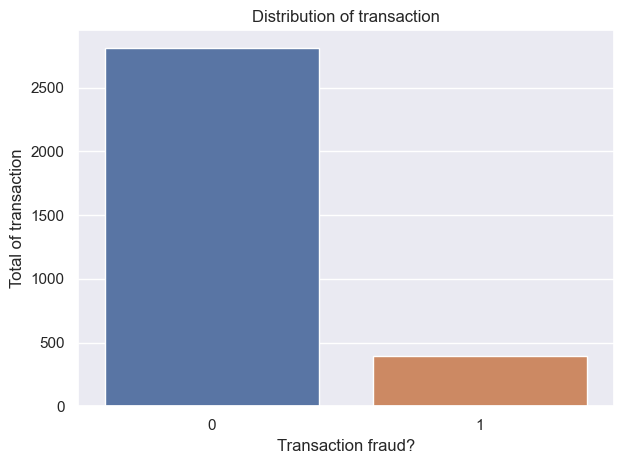

In [70]:
# Plot distribution of transaction with fraud and without fraud

plt.figure(figsize=(10, 7))
fig, ax = plt.subplots(1)

ax = sns.barplot(y="transaction_id",x="has_cbk",data=df,estimator=len).set_title("Distribution of transaction")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xlabel("Transaction fraud?")
plt.ylabel("Total of transaction")
plt.tight_layout()

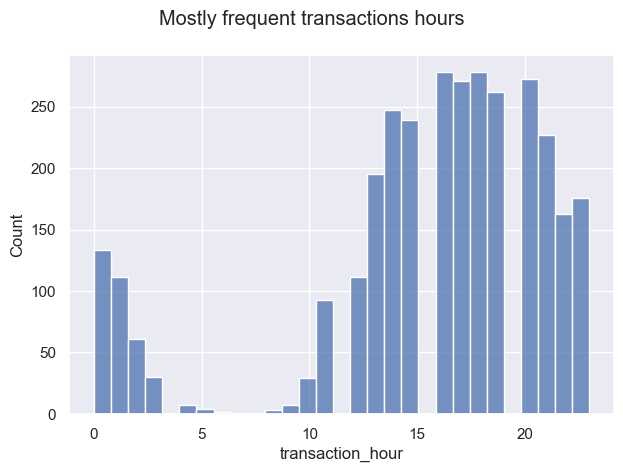

In [71]:
# Plot histogram of transaction hours
fig, ax = plt.subplots(1)
fig.suptitle("Mostly frequent transactions hours")

sns.histplot(data=df, x="transaction_hour")
plt.tight_layout()

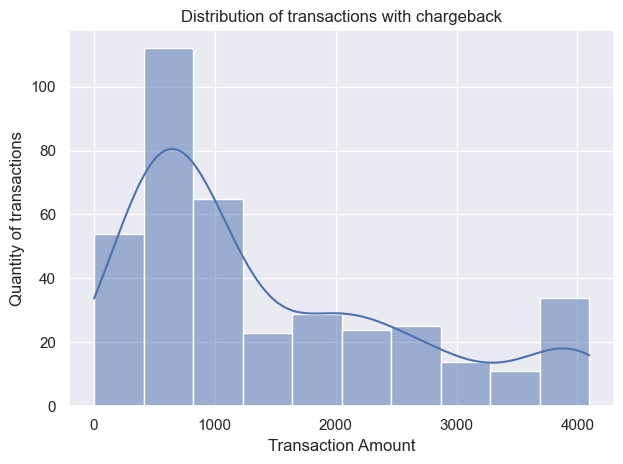

In [72]:
ax = sns.histplot(df.loc[df["has_cbk"] == 1].transaction_amount,kde=True).set_title("Distribution of transactions with chargeback")

plt.xlabel("Transaction Amount")
plt.ylabel("Quantity of transactions")
plt.tight_layout()

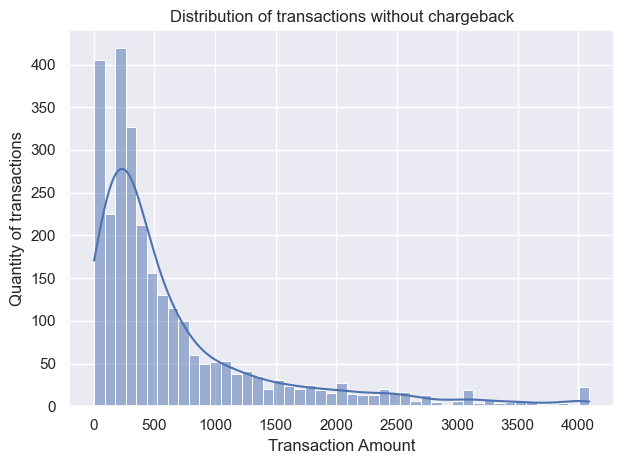

In [73]:
ax = sns.histplot(df.loc[df["has_cbk"] == 0].transaction_amount,kde=True).set_title("Distribution of transactions without chargeback")

plt.xlabel("Transaction Amount")
plt.ylabel("Quantity of transactions")
plt.tight_layout()

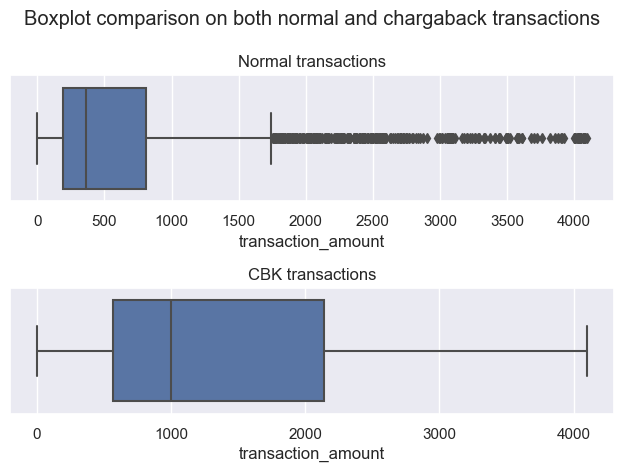

In [74]:
df_norm = df[df["has_cbk"] == 0]
df_cbk = df[df["has_cbk"] == 1]

fig, ax = plt.subplots(2)

fig.suptitle("Boxplot comparison on both normal and chargaback transactions")

sns.boxplot(data = df_norm, x="transaction_amount", ax=ax[0]).set_title("Normal transactions")
sns.boxplot(data = df_cbk, x="transaction_amount", ax=ax[1]).set_title("CBK transactions")

plt.tight_layout()

In [75]:
# Create new column "day of the week"
df["day_of_week"] = df["transaction_date"].dt.day_name()

# Transaction_id occur each day where has_cbk = 1
df[df["has_cbk"] == 1].groupby("day_of_week").transaction_id.nunique()

day_of_week
Friday       120
Monday        20
Saturday      99
Sunday        41
Thursday      61
Tuesday       16
Wednesday     34
Name: transaction_id, dtype: int64

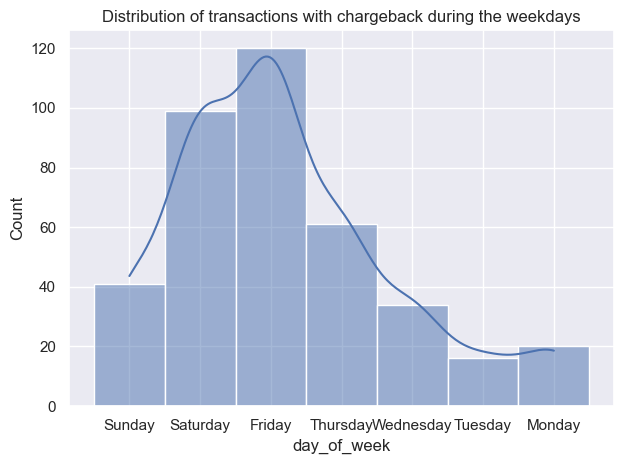

In [76]:
ax = sns.histplot(df.loc[df["has_cbk"] == 1].day_of_week,kde=True).set_title("Distribution of transactions with chargeback during the weekdays")
plt.tight_layout()

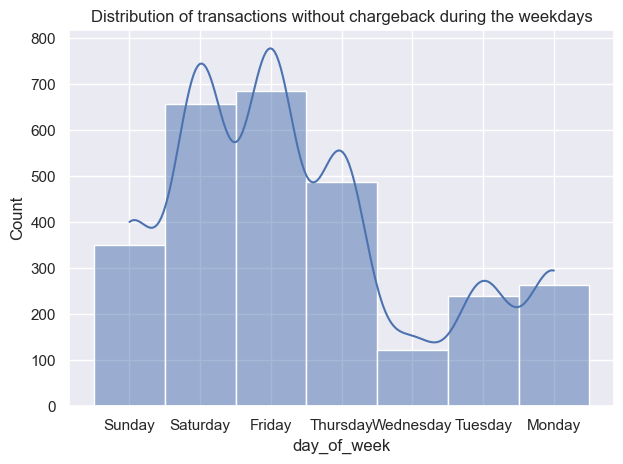

In [77]:
ax = sns.histplot(df.loc[df["has_cbk"] == 0].day_of_week,kde=True).set_title("Distribution of transactions without chargeback during the weekdays")
plt.tight_layout()

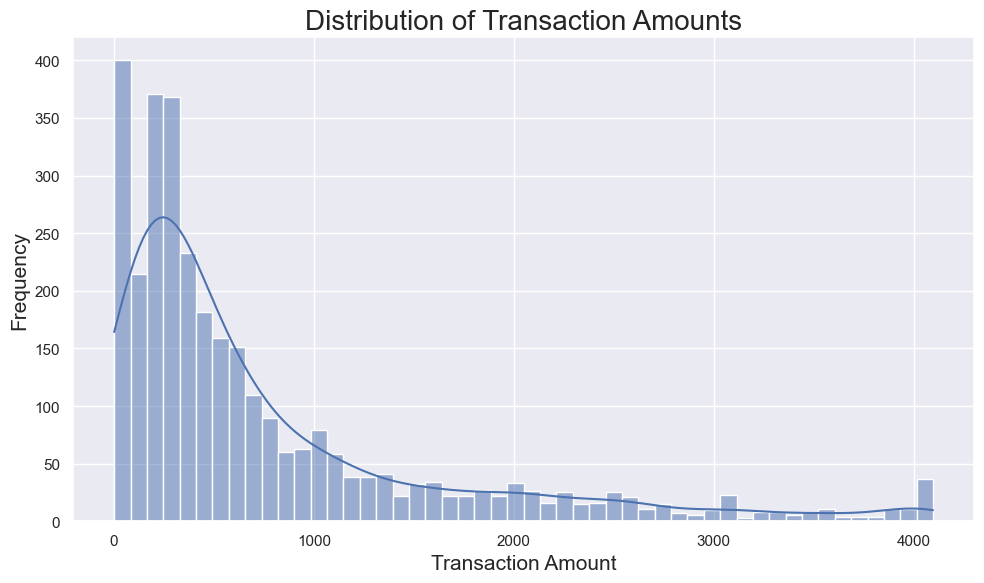

In [78]:
plt.figure(figsize=(10,6))
sns.histplot(df["transaction_amount"], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts", fontsize=20)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.tight_layout()

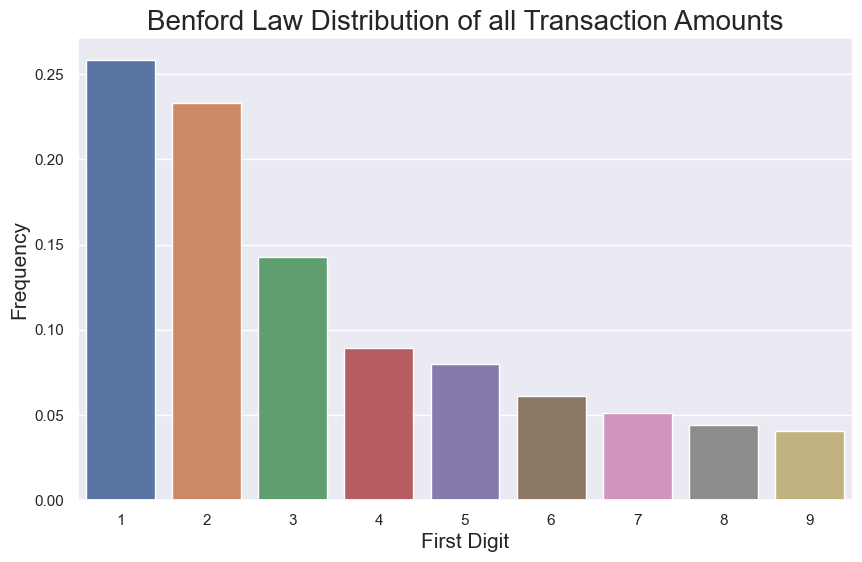

In [79]:
# Creating a Benford's Law plot of the transaction_amount of the whole dataset
benford_data = df["transaction_amount"].apply(lambda x: str(x)[0])
benford_data = benford_data.value_counts(normalize=True).sort_index()

#plotting the distribution of the transaction
plt.figure(figsize=(10,6))
sns.barplot(x=benford_data.index, y=benford_data.values)
plt.title("Benford Law Distribution of all Transaction Amounts", fontsize=20)
plt.xlabel("First Digit", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

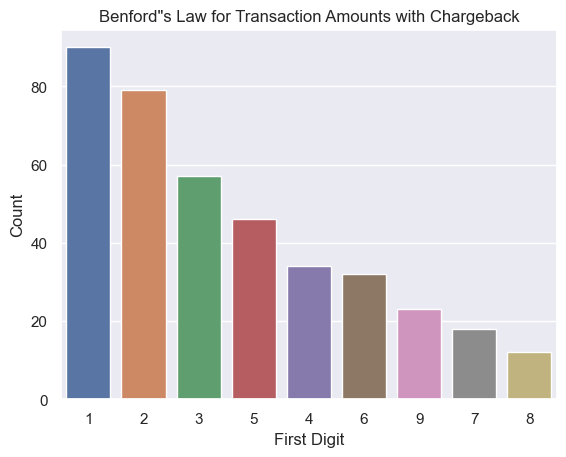

In [80]:
# subset with only the transaction_amount and has_cbk columns
df_subset = df[["transaction_amount", "has_cbk"]]

# Filter the dataframe to only include transactions with has_cbk = 1
df_filtered = df_subset[df_subset["has_cbk"] == 1]

# list of the first digits of the transaction amounts
first_digits = [str(x)[0] for x in df_filtered["transaction_amount"]]

# Dictionary of the counts of the first digits
counts = {x: first_digits.count(x) for x in first_digits}

# Create a dataframe from the dictionary
df_counts = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"])

# Plottings
sns.barplot(x=df_counts.index, y=df_counts["counts"], order=df_counts["counts"].sort_values(ascending=False).index)
plt.xlabel("First Digit")
plt.ylabel("Count")
plt.title("Benford\"s Law for Transaction Amounts with Chargeback")
plt.show()

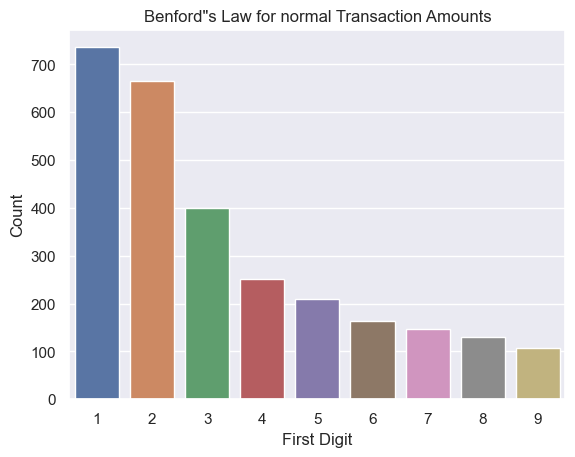

In [81]:
# Replication of the last Benford's Law for Transaction Amounts without Chargeback
df_subset = df[["transaction_amount", "has_cbk"]]
df_filtered = df_subset[df_subset["has_cbk"] == 0]
first_digits = [str(x)[0] for x in df_filtered["transaction_amount"]]
counts = {x: first_digits.count(x) for x in first_digits}
df_counts = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"])

# Add labels to the plot
sns.barplot(x=df_counts.index, y=df_counts["counts"], order=df_counts["counts"].sort_values(ascending=False).index)
plt.xlabel("First Digit")
plt.ylabel("Count")
plt.title("Benford\"s Law for normal Transaction Amounts")
plt.show()

In [82]:
#Detecting cards with unusual number of transactions, rule-based analysis whith more than 2 transactions with at least 1 chargeback

# Group the transactions by card number and count the number of transactions for each card and filter by the rule
card_counts_cbk = df[df["has_cbk"] == 1].groupby("card_number").size().reset_index(name="transactions_cbk")
card_counts_cbk = card_counts_cbk.sort_values(by="transactions_cbk", ascending=False)
suspects_cards = card_counts_cbk[card_counts_cbk["transactions_cbk"] > 2]

# Filter the original dataframe to show only cards that match the rule
suspects_cards = df[df["card_number"].isin(suspects_cards["card_number"])]
suspects_cards.sort_values(by="card_number", ascending=False)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_hour,day_of_week
1314,21321712,89943,86411,651653******2256,2019-11-24 21:09:36,1872.98,597308,1,21,Sunday
1072,21321470,89943,86411,651653******2256,2019-11-27 19:51:01,2030.64,597308,1,19,Wednesday
1803,21322201,89943,86411,651653******2256,2019-11-22 19:11:14,1979.46,597308,1,19,Friday
1431,21321829,89943,86411,651653******2256,2019-11-23 19:54:02,1952.18,597308,1,19,Saturday
2082,21322480,89943,86411,651653******2256,2019-11-21 21:37:36,140.38,597308,1,21,Thursday
...,...,...,...,...,...,...,...,...,...,...
596,21320994,1308,96025,406655******7343,2019-11-29 16:46:59,2288.47,438940,1,16,Friday
692,21321090,1308,79054,406655******7343,2019-11-29 12:51:18,2231.98,101848,1,12,Friday
709,21321107,1308,96025,406655******5764,2019-11-29 11:32:14,2412.28,438940,1,11,Friday
723,21321121,1308,96025,406655******5764,2019-11-29 03:30:44,2486.70,438940,1,3,Friday


In [83]:
#Detecting users with unusual number of transactions
# Group the data by user_id and count the number of transactions per user
user_id_counts = df.groupby("user_id").size().reset_index(name="transactions")
user_id_counts = user_id_counts.sort_values(by="transactions", ascending=False)
user_id_counts

,user_id,transactions
302,11750,31
2448,91637,22
2103,79054,17
2582,96025,14
2085,78262,13
...,...,...
951,36202,1
952,36226,1
953,36292,1
954,36309,1


In [84]:
# Detecting users with unusual number of transactions that already had fraud chargeback label
# Group the data by user_id and count the number of transactions per user
user_frauds = df[df["has_cbk"] == 1].groupby("user_id").size().reset_index(name="transactions with fraud")
user_frauds

,user_id,transactions with fraud
0,900,1
1,2708,1
2,3157,1
3,3584,4
4,4651,3
...,...,...
148,96976,1
149,97150,1
150,97611,2
151,99396,5


In [85]:
# table to check if the users with many transactions had many fraud transactions also
result = pd.merge(user_id_counts, user_frauds, on="user_id",sort=True)
result.sort_values(by="transactions", ascending=False)

,user_id,transactions,transactions with fraud
19,11750,31,25
136,91637,22,19
114,79054,17,15
144,96025,14,13
113,78262,13,12
...,...,...,...
71,50699,1,1
68,45420,1,1
67,45031,1,1
65,44494,1,1


In [86]:
#Detecting cards with unusual number of transactions
# Group the data by card_id and count the number of transactions per card_id
card_id_counts = df.groupby("card_number").size().reset_index(name="transactions")
card_id_counts = card_id_counts.sort_values(by="transactions", ascending=False)

In [87]:
#Detecting users with unusual number of transactions that already had fraud chargeback label
# Group the data by card number and count the number of transactions per card
card_frauds = df[df["has_cbk"] == 1].groupby("card_number").size().reset_index(name="transactions with fraud")

In [91]:
# table to check if the cards with many transactions had many fraud transactions also
result = pd.merge(card_id_counts, card_frauds, on="card_number",sort=True)
result.sort_values(by="transactions", ascending=False)

,card_number,transactions,transactions with fraud
238,554482******7640,10,10
165,530034******3859,6,6
273,651653******2256,5,5
120,498406******7104,4,4
256,606282******5785,4,3
...,...,...,...
109,498401******2440,1,1
110,498401******4043,1,1
111,498401******4982,1,1
112,498401******6342,1,1


In [89]:
# group by merchant_id and count the number of transactions
merchant_id_grouped = df.groupby("merchant_id").size().reset_index(name="transactions_count")

# group by merchant_id and count the number of chargebacks (has_cbk=1)
chargebacks_grouped = df[df["has_cbk"] == 1].groupby("merchant_id").size().reset_index(name="chargebacks_count")

# merge the two grouped dataframes on merchant_id
merchant_analysis = merchant_id_grouped.merge(chargebacks_grouped, on="merchant_id", how="left")

# fill missing values of chargebacks_count with 0
merchant_analysis = merchant_analysis.fillna(0)

# calculate the chargeback rate as chargebacks_count / transactions_count
merchant_analysis["chargeback_rate"] = merchant_analysis["chargebacks_count"] / merchant_analysis["transactions_count"]
merchant_analysis["chargeback_rate"] = round(merchant_analysis["chargeback_rate"],2)

In [90]:
# Rule based check table, where merchant had more than one transaction and at least one chargeback
merchant_analysis[(merchant_analysis["transactions_count"]>1) & (merchant_analysis["chargebacks_count"]>0)]

,merchant_id,transactions_count,chargebacks_count,chargeback_rate
20,1308,15,15.0,1.00
52,3531,2,2.0,1.00
70,4153,6,5.0,0.83
77,4705,22,19.0,0.86
97,5404,4,1.0,0.25
...,...,...,...,...
1637,92895,2,1.0,0.50
1655,94198,2,1.0,0.50
1713,97291,7,4.0,0.57
1729,98272,5,3.0,0.60
